In [1]:
from deepspeed.profiling.flops_profiler.profiler import FlopsProfiler
from models import *
from sample import Sampler
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from metric import accuracy, roc_auc_compute_fn

[2024-11-06 09:35:21,069] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to mps (auto detect)


W1106 09:35:21.910000 46678 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
class Custom_Profiler:
    def __init__(self, model):
        assert isinstance(model, torch.nn.Module)
        self.model = model.eval()

    def get_model_profile(self, data):
        model = self.model
        model.eval()
        prof = FlopsProfiler(model)

        prof.start_profile()
        #print(data)
        _ = model(**data)
        flops = prof.get_total_flops()
        macs = prof.get_total_macs()
        prof.end_profile()
        prof.reset_profile()

        return flops, macs

dataset_config = {
    'cora':{
        'nclass':7,
        'nfeat':1433,
        'withloop':False,
    },
    'citeseer':{
        'nclass':6,
        'nfeat':3703,
        'withloop':True,
    },
    'pubmed':{
        'nclass':3,
        'nfeat':500,
        'withloop':True,
    },
}

In [3]:
path_list = list(Path('./tmpmodel').glob('*.pt'))
path_list

[PosixPath('tmpmodel/mutigcn_0.05_citeseer_1_128-1105-150719-NsQ.pt'),
 PosixPath('tmpmodel/densegcn_1.0_cora_1_256-1105-143959-Tjo.pt'),
 PosixPath('tmpmodel/mutigcn_0.7_cora_4_64-1105-143336-WaY.pt'),
 PosixPath('tmpmodel/densegcn_1.0_cora_4_64-1105-144020-Yud.pt'),
 PosixPath('tmpmodel/densegcn_1.0_cora_1_64-1105-143918-wFz.pt'),
 PosixPath('tmpmodel/mutigcn_0.3_pubmed_4_64-1105-135414-hiQ.pt'),
 PosixPath('tmpmodel/mutigcn_1.0_citeseer_16_256-1105-151541-AKu.pt'),
 PosixPath('tmpmodel/mutigcn_0.7_cora_16_64-1105-143430-Rtk.pt'),
 PosixPath('tmpmodel/mutigcn_1.0_citeseer_4_128-1105-151312-VfB.pt'),
 PosixPath('tmpmodel/densegcn_0.6_citeseer_1_64-1105-145624-pED.pt'),
 PosixPath('tmpmodel/densegcn_0.2_cora_1_64-1105-141305-rxD.pt'),
 PosixPath('tmpmodel/mutigcn_0.05_citeseer_16_256-1105-151058-WiJ.pt'),
 PosixPath('tmpmodel/densegcn_0.5_pubmed_1_64-1105-134354-HSB.pt'),
 PosixPath('tmpmodel/mutigcn_1.0_pubmed_1_256-1105-135948-wNd.pt'),
 PosixPath('tmpmodel/densegcn_0.2_cora_16_128-1

In [4]:
#path_list = list(filter(lambda x: 'densegcn'  in str(x), path_list))
#path_list

In [5]:
loss_log = pd.read_csv('/Users/mew.ac/DropEdge/data.csv')
loss_log['loss_train'] = loss_log['loss_trian']
del loss_log['loss_trian']

In [6]:
res = {
    'arch':[],
    'dataset':[],
    'num_layers':[],
    'num_hidden':[],
    'flops':[],
    'macs':[],
    'acc_test':[],
}
for fpath in tqdm(path_list):
    #fpath = 'tmpmodel/mutigcn_1.0_pubmed_1_256-1105-122612-KsF.pt'
    splits = str(fpath).split('/')[-1].split('_')
    type = splits[0]
    sampling_percent = float(splits[1])
    if type == 'densegcn':
        if sampling_percent < 1.0:
            arch = 'JKNet'
        else:
            arch = 'JKNet_nodrop'
    else:
        if sampling_percent < 1.0:
            arch = 'GCN'
        else:
            arch = 'GCN_nodrop'
    dataset = splits[2].lower()
    num_layers = int(splits[3])
    num_hidden = int(splits[4].split('-')[0])
    if 'nodrop' in arch:
        sampling_percent = 1.0
    elif dataset == 'cora':
        if arch == 'GCN':
            sampling_percent = 0.7
        else:
            sampling_percent = 0.2
    elif dataset == 'citeseer':
        if arch == 'GCN':
            sampling_percent = 0.05
        else:
            sampling_percent = 0.6
    else:
        if arch == 'GCN':
            sampling_percent = 0.3
        else:
            sampling_percent = 0.5

    if 'GCN' in arch:
        baseblock = 'mutigcn'
    else:
        baseblock = 'densegcn'

    if dataset == 'pubmed':
        withbn = True
    elif dataset == 'citeseer' and 'GCN' in arch:
        withbn = True
    else:
        withbn = False

    if 'GCN' in arch:
        nbaseblocklayer = 2
    elif dataset == 'citeseer':
        nbaseblocklayer = 6
    elif dataset == 'cora':
        nbaseblocklayer = 14
    elif dataset == 'pubmed':
        nbaseblocklayer = 62

    if 'JKNet' in arch:
        normalization = 'AugNormAdj'
    elif dataset == 'cora':
        normalization = 'FirstOrderGCN'
    else:
        normalization = 'BingGeNormAdj'

    row_name = '_'.join([type, str(sampling_percent), dataset, str(num_layers), str(num_hidden)])
    try:
        acc_test = float(loss_log[loss_log['name']==row_name]['acc_test'].iloc[0])
    except:
        continue
    sampler = Sampler(dataset, '../data', 'full')
    labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(False)

    #print(arch, num_hidden, num_layers, dataset_config[dataset]['nfeat'], dataset_config[dataset]['nclass'], dataset)
    #print(baseblock, nbaseblocklayer, withbn, sampling_percent)
    model = GCNModel(nfeat=dataset_config[dataset]['nfeat'],
                    nhid=num_hidden,
                    nclass=dataset_config[dataset]['nclass'],
                    nhidlayer=num_layers,
                    dropout=0, # no effct during eval.
                    baseblock=baseblock,
                    inputlayer='gcn',
                    outputlayer='gcn',
                    nbaselayer=nbaseblocklayer,
                    activation=F.relu,
                    withbn=withbn,    
                    withloop=dataset_config[dataset]['withloop'],
                    aggrmethod='nores' if baseblock == 'mutigcn' else 'concat',
                    mixmode=False)
    #print(model)
    model.load_state_dict(torch.load(fpath, weights_only=True, map_location=torch.device('cpu')))
    model.eval()

    cp = Custom_Profiler(model)
    data = sampler.randomedge_sampler(percent=sampling_percent, normalization=normalization, cuda=False)
    data_dict = {
        'adj':data[0],
        'fea':data[1],
    }
    flops, macs = cp.get_model_profile(data_dict)

    #print(fpath)
    #print(flops, macs)
    res['arch'].append(arch)
    res['num_layers'].append(num_layers)
    res['num_hidden'].append(num_hidden)
    res['flops'].append(flops)
    res['macs'].append(macs)

    res['acc_test'].append(acc_test)
    res['dataset'].append(dataset)
    #res['test_loss'] = res['test_loss'].append(loss_test)
    #res['train_acc'] = res['train_acc'].append()
    #res['val_acc'] = res['val_acc'].append()
    #res['train_loss'] = res['train_loss'].append()
    #res['val_loss'] = res['val_loss'].append()

  0%|          | 0/98 [00:00<?, ?it/s]

Load full supervised task.
[2024-11-06 09:35:23,497] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:23,516] [INFO] [profiler.py:227:end_profile] Flops profiler finished


/Users/mew.ac/DropEdge/src/normalization.py:110: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()
/Users/mew.ac/DropEdge/src/utils.py:33: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/torch/csrc/utils/tensor_new.cpp:653.)
  return torch.sparse.FloatTensor(indices, values, shape)
  1%|          | 1/98 [00:00<00:43,  2.22it/s]

Load full supervised task.
[2024-11-06 09:35:23,612] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:23,688] [INFO] [profiler.py:227:end_profile] Flops profiler finished


  2%|▏         | 2/98 [00:00<00:27,  3.48it/s]

Load full supervised task.
[2024-11-06 09:35:23,778] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:23,784] [INFO] [profiler.py:227:end_profile] Flops profiler finished
Load full supervised task.
[2024-11-06 09:35:23,879] [INFO] [profiler.py:81:start_profile] Flops profiler started


/Users/mew.ac/DropEdge/src/normalization.py:25: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(row_sum, -0.5).flatten()


[2024-11-06 09:35:23,999] [INFO] [profiler.py:227:end_profile] Flops profiler finished


  4%|▍         | 4/98 [00:00<00:19,  4.86it/s]

Load full supervised task.
[2024-11-06 09:35:24,094] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:24,106] [INFO] [profiler.py:227:end_profile] Flops profiler finished


  5%|▌         | 5/98 [00:01<00:16,  5.75it/s]

Load full supervised task.
[2024-11-06 09:35:24,509] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:24,556] [INFO] [profiler.py:227:end_profile] Flops profiler finished


  6%|▌         | 6/98 [00:01<00:23,  3.86it/s]

Load full supervised task.
[2024-11-06 09:35:24,949] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:25,104] [INFO] [profiler.py:227:end_profile] Flops profiler finished


  7%|▋         | 7/98 [00:02<00:31,  2.87it/s]

Load full supervised task.
[2024-11-06 09:35:25,210] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:25,226] [INFO] [profiler.py:227:end_profile] Flops profiler finished


  8%|▊         | 8/98 [00:02<00:25,  3.59it/s]

Load full supervised task.
[2024-11-06 09:35:25,525] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:25,546] [INFO] [profiler.py:227:end_profile] Flops profiler finished


  9%|▉         | 9/98 [00:02<00:25,  3.44it/s]

Load full supervised task.
[2024-11-06 09:35:25,843] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:25,855] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 10%|█         | 10/98 [00:02<00:26,  3.38it/s]

Load full supervised task.
[2024-11-06 09:35:25,947] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:25,956] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 11%|█         | 11/98 [00:02<00:20,  4.22it/s]

Load full supervised task.
[2024-11-06 09:35:26,303] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:26,380] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 12%|█▏        | 12/98 [00:03<00:25,  3.38it/s]

Load full supervised task.
[2024-11-06 09:35:26,737] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:27,773] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 13%|█▎        | 13/98 [00:04<00:53,  1.59it/s]

Load full supervised task.
[2024-11-06 09:35:28,139] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:28,207] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 14%|█▍        | 14/98 [00:05<00:47,  1.77it/s]

Load full supervised task.
[2024-11-06 09:35:28,305] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:28,331] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 16%|█▋        | 16/98 [00:05<00:27,  3.00it/s]

Load full supervised task.
[2024-11-06 09:35:28,502] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:28,526] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 17%|█▋        | 17/98 [00:05<00:24,  3.35it/s]

Load full supervised task.
[2024-11-06 09:35:28,629] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:28,646] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 18%|█▊        | 18/98 [00:05<00:20,  3.98it/s]

Load full supervised task.
[2024-11-06 09:35:28,966] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:29,006] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 19%|█▉        | 19/98 [00:05<00:22,  3.55it/s]

Load full supervised task.
[2024-11-06 09:35:29,378] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:29,549] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 20%|██        | 20/98 [00:06<00:27,  2.80it/s]

Load full supervised task.
[2024-11-06 09:35:29,860] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:29,883] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 21%|██▏       | 21/98 [00:06<00:26,  2.88it/s]

Load full supervised task.
[2024-11-06 09:35:29,999] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:30,044] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 22%|██▏       | 22/98 [00:06<00:22,  3.40it/s]

Load full supervised task.
[2024-11-06 09:35:30,366] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:30,442] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 23%|██▎       | 23/98 [00:07<00:24,  3.07it/s]

Load full supervised task.
[2024-11-06 09:35:30,749] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:30,760] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 24%|██▍       | 24/98 [00:07<00:23,  3.11it/s]

Load full supervised task.
[2024-11-06 09:35:31,079] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:31,097] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 26%|██▌       | 25/98 [00:08<00:23,  3.07it/s]

Load full supervised task.
[2024-11-06 09:35:31,398] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:31,431] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 27%|██▋       | 26/98 [00:08<00:23,  3.03it/s]

Load full supervised task.
[2024-11-06 09:35:31,775] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:32,016] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 28%|██▊       | 27/98 [00:08<00:29,  2.44it/s]

Load full supervised task.
[2024-11-06 09:35:32,717] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:34,954] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 29%|██▊       | 28/98 [00:11<01:22,  1.17s/it]

Load full supervised task.
[2024-11-06 09:35:35,171] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:36,491] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 30%|██▉       | 29/98 [00:13<01:28,  1.28s/it]

Load full supervised task.
[2024-11-06 09:35:36,865] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:36,908] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 32%|███▏      | 31/98 [00:13<00:52,  1.29it/s]

Load full supervised task.
[2024-11-06 09:35:37,271] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:37,421] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 33%|███▎      | 32/98 [00:14<00:47,  1.40it/s]

Load full supervised task.
[2024-11-06 09:35:37,525] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:37,543] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 34%|███▎      | 33/98 [00:14<00:36,  1.79it/s]

Load full supervised task.
[2024-11-06 09:35:37,640] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:37,644] [INFO] [profiler.py:227:end_profile] Flops profiler finished
Load full supervised task.
[2024-11-06 09:35:38,018] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:38,031] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 36%|███▌      | 35/98 [00:14<00:26,  2.37it/s]

Load full supervised task.
[2024-11-06 09:35:38,310] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:40,243] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 37%|███▋      | 36/98 [00:17<00:52,  1.17it/s]

Load full supervised task.
[2024-11-06 09:35:40,607] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:40,692] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 38%|███▊      | 37/98 [00:17<00:45,  1.35it/s]

Load full supervised task.
[2024-11-06 09:35:41,348] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:43,361] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 39%|███▉      | 38/98 [00:20<01:15,  1.26s/it]

Load full supervised task.
[2024-11-06 09:35:43,721] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:43,747] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 40%|███▉      | 39/98 [00:20<00:59,  1.01s/it]

Load full supervised task.
[2024-11-06 09:35:44,075] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:44,153] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 41%|████      | 40/98 [00:21<00:48,  1.19it/s]

Load full supervised task.
[2024-11-06 09:35:44,667] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:50,331] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 42%|████▏     | 41/98 [00:27<02:16,  2.40s/it]

Load full supervised task.
[2024-11-06 09:35:50,575] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:50,629] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 43%|████▎     | 42/98 [00:27<01:38,  1.76s/it]

Load full supervised task.
[2024-11-06 09:35:50,866] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:51,253] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 44%|████▍     | 43/98 [00:28<01:18,  1.43s/it]

Load full supervised task.
[2024-11-06 09:35:51,604] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:51,639] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 45%|████▍     | 44/98 [00:28<01:00,  1.12s/it]

Load full supervised task.
[2024-11-06 09:35:51,743] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:51,853] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 46%|████▌     | 45/98 [00:28<00:45,  1.18it/s]

Load full supervised task.
[2024-11-06 09:35:51,967] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:52,149] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 47%|████▋     | 46/98 [00:29<00:35,  1.46it/s]

Load full supervised task.
[2024-11-06 09:35:52,496] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:52,898] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 48%|████▊     | 47/98 [00:29<00:36,  1.41it/s]

Load full supervised task.
[2024-11-06 09:35:53,037] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:53,044] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 49%|████▉     | 48/98 [00:29<00:26,  1.87it/s]

Load full supervised task.
[2024-11-06 09:35:53,340] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:53,353] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 50%|█████     | 49/98 [00:30<00:22,  2.14it/s]

Load full supervised task.
[2024-11-06 09:35:53,664] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:53,708] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 51%|█████     | 50/98 [00:30<00:20,  2.29it/s]

Load full supervised task.
[2024-11-06 09:35:54,019] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:54,062] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 52%|█████▏    | 51/98 [00:31<00:19,  2.44it/s]

Load full supervised task.
[2024-11-06 09:35:54,544] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:55,338] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 53%|█████▎    | 52/98 [00:32<00:31,  1.47it/s]

Load full supervised task.
[2024-11-06 09:35:55,712] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:55,893] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 54%|█████▍    | 53/98 [00:32<00:28,  1.58it/s]

Load full supervised task.
[2024-11-06 09:35:56,262] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:57,182] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 55%|█████▌    | 54/98 [00:34<00:36,  1.20it/s]

Load full supervised task.
[2024-11-06 09:35:57,307] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:57,316] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 56%|█████▌    | 55/98 [00:34<00:26,  1.62it/s]

Load full supervised task.
[2024-11-06 09:35:57,638] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:57,666] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 57%|█████▋    | 56/98 [00:34<00:22,  1.86it/s]

Load full supervised task.
[2024-11-06 09:35:57,779] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:58,001] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 58%|█████▊    | 57/98 [00:34<00:19,  2.08it/s]

Load full supervised task.
[2024-11-06 09:35:58,319] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:58,342] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 59%|█████▉    | 58/98 [00:35<00:17,  2.30it/s]

Load full supervised task.
[2024-11-06 09:35:58,691] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:58,976] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 60%|██████    | 59/98 [00:35<00:19,  2.00it/s]

Load full supervised task.
[2024-11-06 09:35:59,337] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:35:59,418] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 61%|██████    | 60/98 [00:36<00:18,  2.09it/s]

Load full supervised task.
[2024-11-06 09:35:59,763] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:00,190] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 62%|██████▏   | 61/98 [00:37<00:21,  1.73it/s]

Load full supervised task.
[2024-11-06 09:36:00,530] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:00,539] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 63%|██████▎   | 62/98 [00:37<00:17,  2.01it/s]

Load full supervised task.
[2024-11-06 09:36:00,635] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:00,642] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 64%|██████▍   | 63/98 [00:37<00:13,  2.64it/s]

Load full supervised task.
[2024-11-06 09:36:00,961] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:01,013] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 65%|██████▌   | 64/98 [00:37<00:12,  2.62it/s]

Load full supervised task.
[2024-11-06 09:36:01,127] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:01,156] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 66%|██████▋   | 65/98 [00:38<00:10,  3.27it/s]

Load full supervised task.
[2024-11-06 09:36:01,264] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:01,336] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 67%|██████▋   | 66/98 [00:38<00:08,  3.70it/s]

Load full supervised task.
[2024-11-06 09:36:01,441] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:01,445] [INFO] [profiler.py:227:end_profile] Flops profiler finished
Load full supervised task.
[2024-11-06 09:36:01,829] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:01,840] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 70%|███████   | 69/98 [00:38<00:06,  4.73it/s]

Load full supervised task.
[2024-11-06 09:36:02,198] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:02,710] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 71%|███████▏  | 70/98 [00:39<00:09,  2.82it/s]

Load full supervised task.
[2024-11-06 09:36:03,057] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:03,112] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 72%|███████▏  | 71/98 [00:40<00:09,  2.78it/s]

Load full supervised task.
[2024-11-06 09:36:03,410] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:03,434] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 73%|███████▎  | 72/98 [00:40<00:09,  2.85it/s]

Load full supervised task.
[2024-11-06 09:36:03,768] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:03,935] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 74%|███████▍  | 73/98 [00:40<00:09,  2.55it/s]

Load full supervised task.
[2024-11-06 09:36:04,253] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:04,293] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 76%|███████▌  | 74/98 [00:41<00:09,  2.62it/s]

Load full supervised task.
[2024-11-06 09:36:04,627] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:04,783] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 77%|███████▋  | 75/98 [00:41<00:09,  2.42it/s]

Load full supervised task.
[2024-11-06 09:36:05,129] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:05,150] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 78%|███████▊  | 76/98 [00:42<00:08,  2.51it/s]

Load full supervised task.
[2024-11-06 09:36:05,267] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:05,274] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 79%|███████▊  | 77/98 [00:42<00:06,  3.14it/s]

Load full supervised task.
[2024-11-06 09:36:05,507] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:08,087] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 80%|███████▉  | 78/98 [00:45<00:21,  1.07s/it]

Load full supervised task.
[2024-11-06 09:36:08,476] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:08,587] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 81%|████████  | 79/98 [00:45<00:16,  1.13it/s]

Load full supervised task.
[2024-11-06 09:36:08,993] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:13,389] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 82%|████████▏ | 80/98 [00:50<00:37,  2.07s/it]

Load full supervised task.
[2024-11-06 09:36:13,794] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:13,824] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 83%|████████▎ | 81/98 [00:50<00:26,  1.56s/it]

Load full supervised task.
[2024-11-06 09:36:13,922] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:13,926] [INFO] [profiler.py:227:end_profile] Flops profiler finished
Load full supervised task.
[2024-11-06 09:36:14,305] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:17,974] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 85%|████████▍ | 83/98 [00:55<00:27,  1.82s/it]

Load full supervised task.
[2024-11-06 09:36:18,197] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:18,215] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 86%|████████▌ | 84/98 [00:55<00:19,  1.40s/it]

Load full supervised task.
[2024-11-06 09:36:18,607] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:18,660] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 87%|████████▋ | 85/98 [00:55<00:14,  1.15s/it]

Load full supervised task.
[2024-11-06 09:36:19,023] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:20,783] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 88%|████████▊ | 86/98 [00:57<00:17,  1.42s/it]

Load full supervised task.
[2024-11-06 09:36:21,119] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:21,133] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 89%|████████▉ | 87/98 [00:58<00:12,  1.11s/it]

Load full supervised task.
[2024-11-06 09:36:21,512] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:22,159] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 91%|█████████ | 89/98 [00:59<00:07,  1.17it/s]

Load full supervised task.
[2024-11-06 09:36:22,537] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:22,597] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 92%|█████████▏| 90/98 [00:59<00:05,  1.34it/s]

Load full supervised task.
[2024-11-06 09:36:22,696] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:22,705] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 93%|█████████▎| 91/98 [00:59<00:04,  1.71it/s]

Load full supervised task.
[2024-11-06 09:36:22,857] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:24,288] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 94%|█████████▍| 92/98 [01:01<00:05,  1.16it/s]

Load full supervised task.
[2024-11-06 09:36:24,630] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:24,654] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 95%|█████████▍| 93/98 [01:01<00:03,  1.40it/s]

Load full supervised task.
[2024-11-06 09:36:25,074] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:25,793] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 96%|█████████▌| 94/98 [01:02<00:03,  1.19it/s]

Load full supervised task.
[2024-11-06 09:36:26,124] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:26,168] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 97%|█████████▋| 95/98 [01:03<00:02,  1.43it/s]

Load full supervised task.
[2024-11-06 09:36:26,279] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:26,285] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 98%|█████████▊| 96/98 [01:03<00:01,  1.89it/s]

Load full supervised task.
[2024-11-06 09:36:26,412] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:26,461] [INFO] [profiler.py:227:end_profile] Flops profiler finished


 99%|█████████▉| 97/98 [01:03<00:00,  2.34it/s]

Load full supervised task.
[2024-11-06 09:36:26,617] [INFO] [profiler.py:81:start_profile] Flops profiler started
[2024-11-06 09:36:26,952] [INFO] [profiler.py:227:end_profile] Flops profiler finished


100%|██████████| 98/98 [01:03<00:00,  1.53it/s]


In [7]:
df = pd.DataFrame(res)

In [ ]:
df['acc_test'] = df['acc_test'] * 100

In [144]:
df = df.sort_values(['num_layers','num_hidden'])
df['gflops'] = df['flops'] / 1e9
df['gmacs'] = df['macs'] / 1e9

In [145]:
import seaborn as sns

/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2301600584.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)
/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2301600584.py:27: RuntimeWarning: invalid value encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)


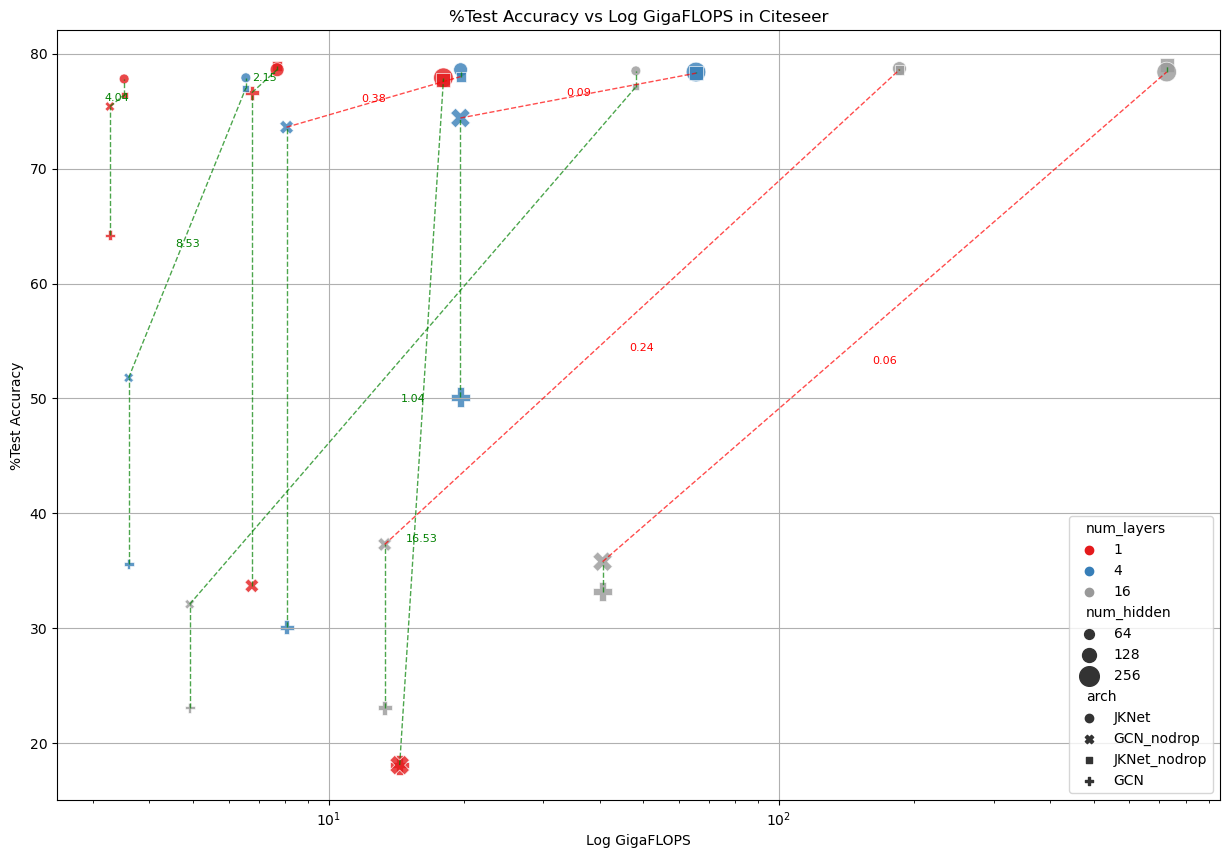

/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2301600584.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)
/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2301600584.py:27: RuntimeWarning: invalid value encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)


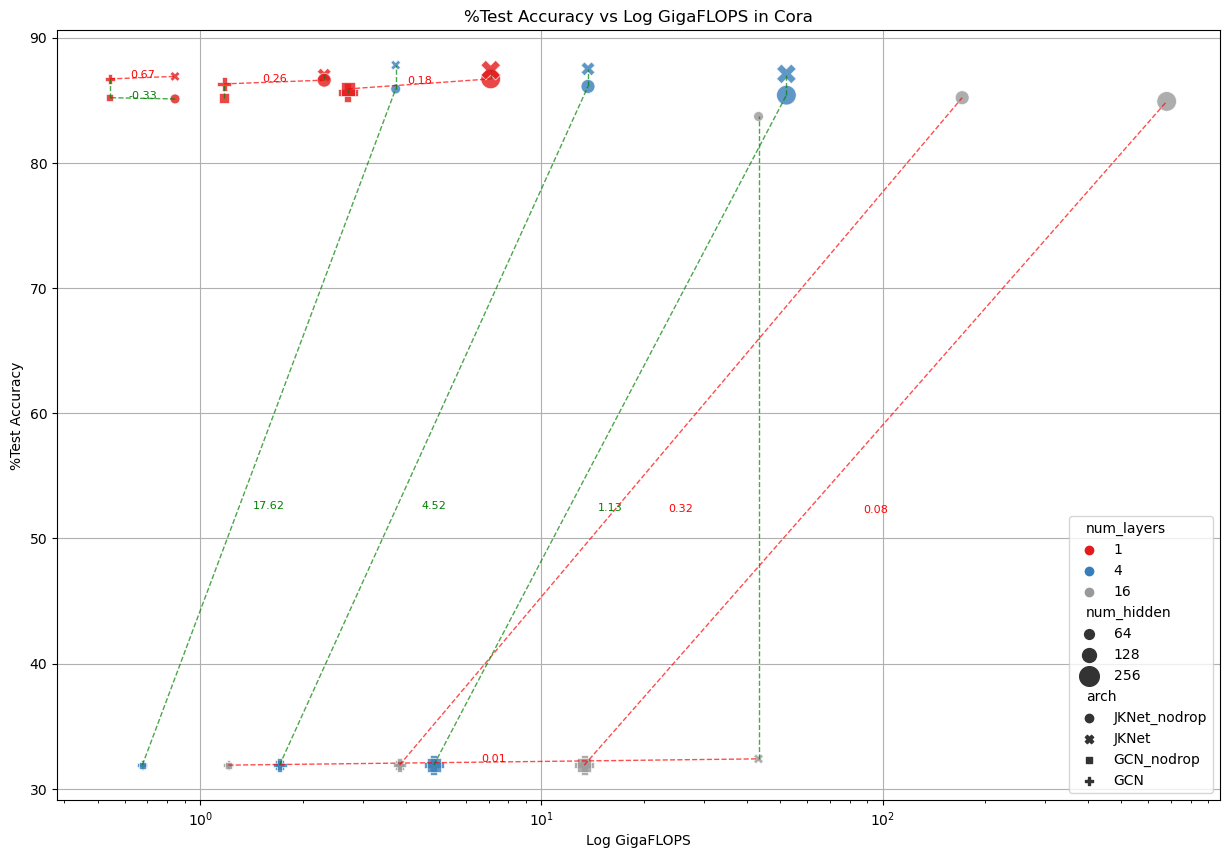

/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2301600584.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)
/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2301600584.py:27: RuntimeWarning: invalid value encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)


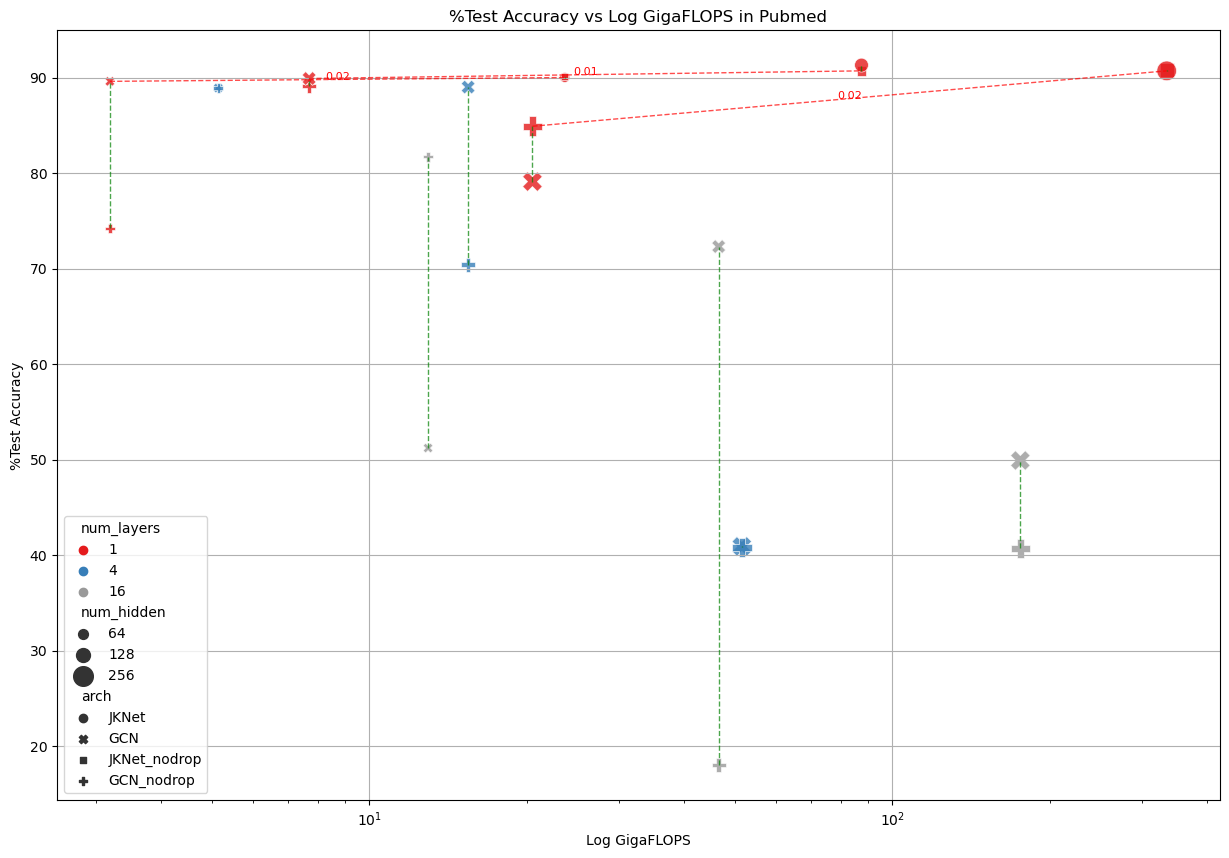

In [146]:

palette = sns.color_palette("Set1", as_cmap=True)

for ds in ['citeseer','cora','pubmed']:
    plt.figure(figsize=(15,10))
    sns.scatterplot(df[df['dataset']==ds], x='gflops', y='acc_test',hue='num_layers',style='arch',size='num_hidden', sizes={64:50,128:100,256:200,}, palette=palette,alpha=0.8)

    # Iterate through unique combinations of num_layers and num_hidden
    for (num_hidden, num_layers), group_data in df[df['dataset'] == ds].groupby(['num_hidden', 'num_layers']):
        # Sort by architecture if needed to maintain a logical connection order
        group_data = group_data.sort_values(by=['acc_test','flops'])
        
        # Draw a line connecting points with the same num_hidden and num_layers across different architectures
        #plt.plot(
        #    group_data['gflops'], 
        #    group_data['acc_test'], 
        #    color='gray', 
        #    linestyle='--', 
        #    linewidth=1, 
        #    alpha=0.75
        #)
        # Calculate the rate of change in accuracy relative to GFLOPS
        for i in range(len(group_data) - 1):
            x1, y1 = group_data.iloc[i]['gflops'], group_data.iloc[i]['acc_test']
            x2, y2 = group_data.iloc[i + 1]['gflops'], group_data.iloc[i + 1]['acc_test']
            
            # Percentage change in accuracy per GFLOPS step
            rate_of_change = (y2 - y1) / (x2 - x1)
            
            # Define the color based on the rate of change (positive = green, negative = red)
            if rate_of_change < 0:
                if abs(rate_of_change) > 1:
                    color = 'red'
                else:
                    color = 'green'
            else:
                if abs(rate_of_change) > 1:
                    color = 'green'
                else:
                    color = 'red'
            midpoint_x = np.sqrt(x1 * x2)  # Geometric mean for x-axis
            midpoint_y = np.sqrt(y1 * y2)  # Geometric mean for y-axis
            # Annotate the rate of change at the midpoint of the line segment
            plt.plot(
                [x1, x2], [y1, y2], 
                color=color, 
                linestyle='--', 
                linewidth=1, 
                alpha=0.7
            )
            if np.isnan(rate_of_change) or np.isinf(rate_of_change):
                continue
            plt.text(
                midpoint_x, midpoint_y, 
                f'{rate_of_change:.2f}', 
                color=color, 
                fontsize=8, 
                ha='center'
            )

    plt.grid()
    plt.xscale('log')
    #plt.yscale('log')
    plt.title(f'%Test Accuracy vs Log GigaFLOPS in {ds.capitalize()}')
    plt.ylabel('%Test Accuracy')
    plt.xlabel('Log GigaFLOPS')
    plt.savefig(f'{ds}_gflops.png')
    plt.show()

/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2009344454.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)
/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2009344454.py:27: RuntimeWarning: invalid value encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)


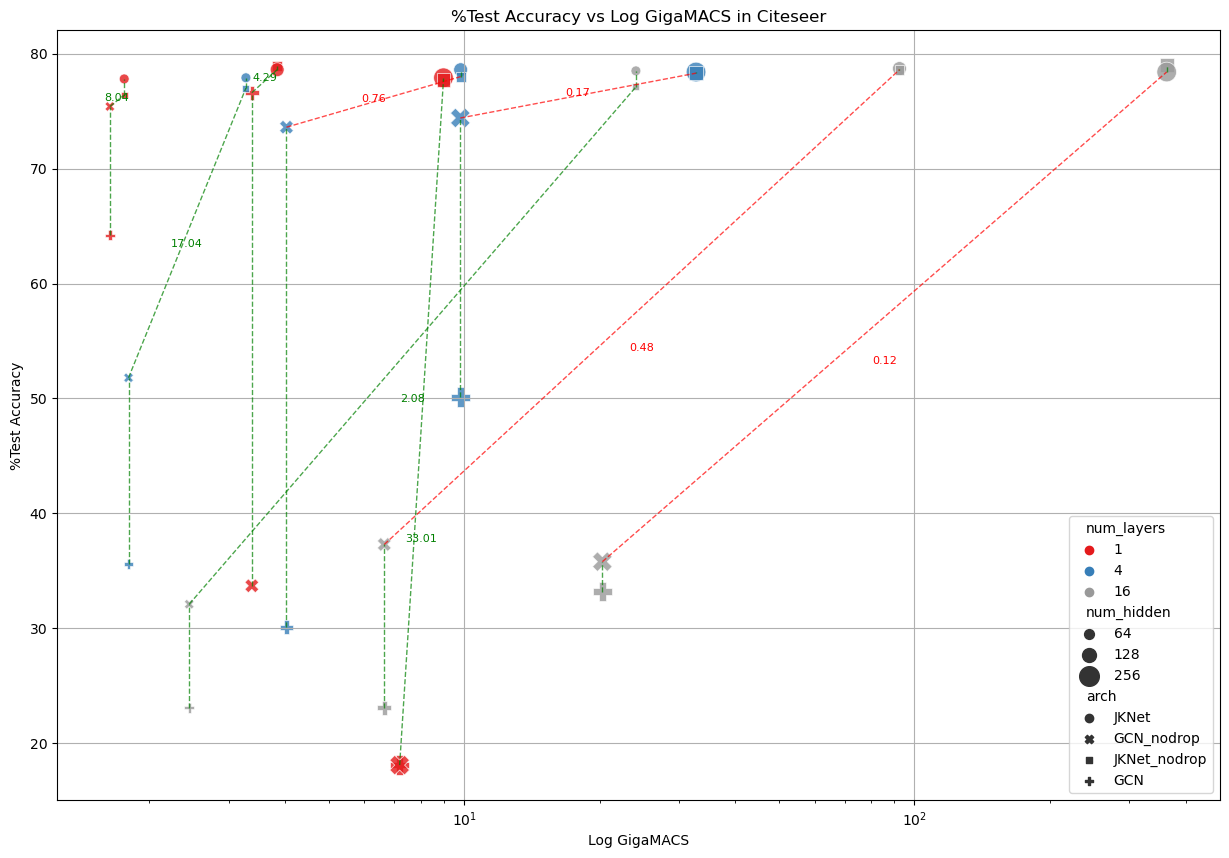

/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2009344454.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)
/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2009344454.py:27: RuntimeWarning: invalid value encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)


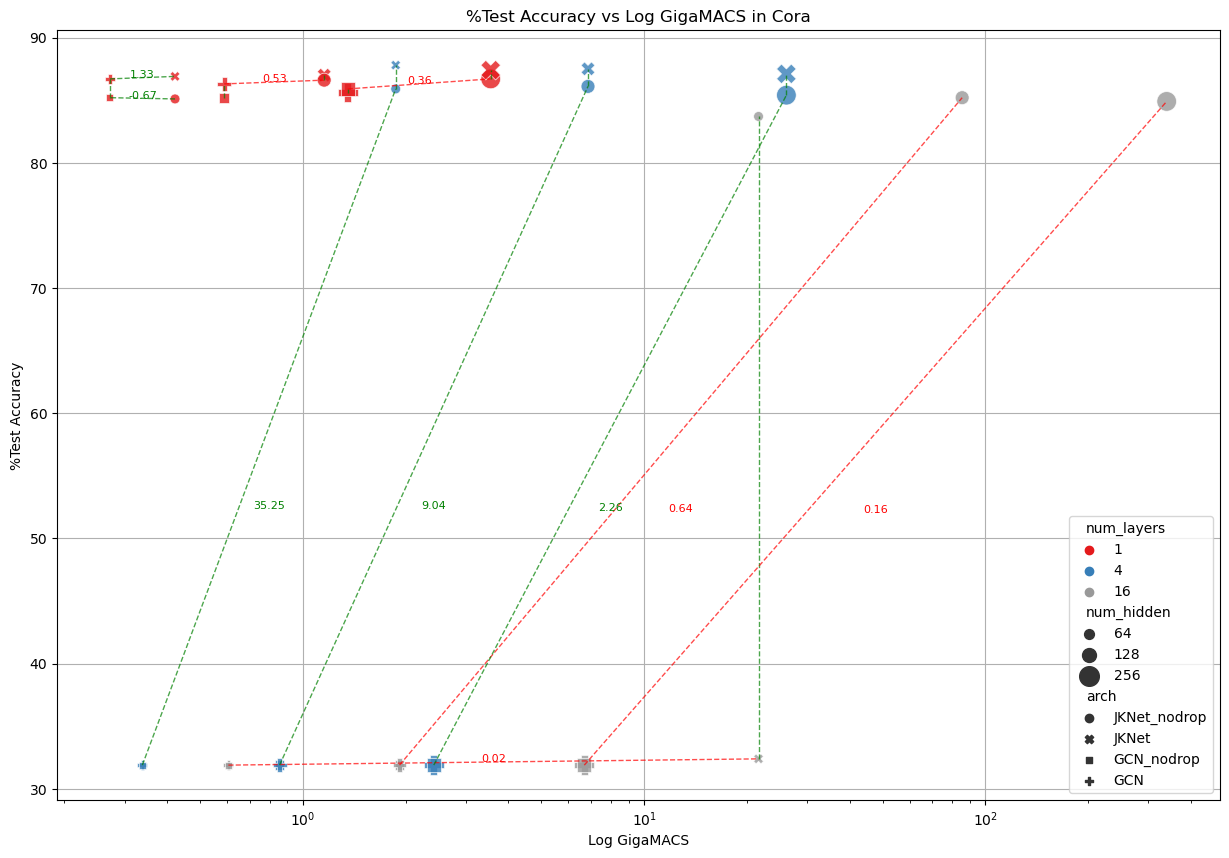

/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2009344454.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)
/var/folders/s5/3ylbsjrs09s_kg094mq61_x80000gn/T/ipykernel_46678/2009344454.py:27: RuntimeWarning: invalid value encountered in scalar divide
  rate_of_change = (y2 - y1) / (x2 - x1)


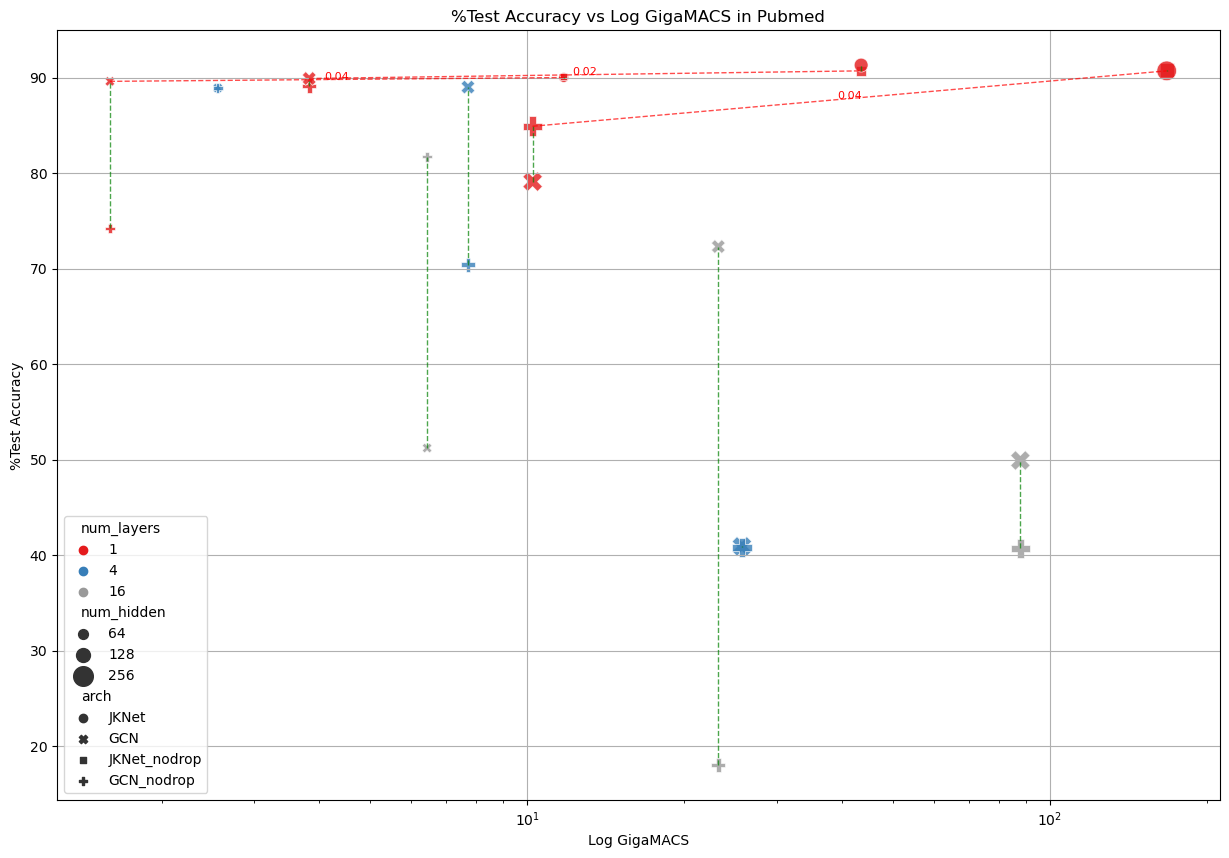

In [147]:

palette = sns.color_palette("Set1", as_cmap=True)

for ds in ['citeseer','cora','pubmed']:
    plt.figure(figsize=(15,10))
    sns.scatterplot(df[df['dataset']==ds], x='gmacs', y='acc_test',hue='num_layers',style='arch',size='num_hidden', sizes={64:50,128:100,256:200,}, palette=palette,alpha=0.8)

    # Iterate through unique combinations of num_layers and num_hidden
    for (num_hidden, num_layers), group_data in df[df['dataset'] == ds].groupby(['num_hidden', 'num_layers']):
        # Sort by architecture if needed to maintain a logical connection order
        group_data = group_data.sort_values(by=['acc_test','gmacs'])
        
        # Draw a line connecting points with the same num_hidden and num_layers across different architectures
        #plt.plot(
        #    group_data['gflops'], 
        #    group_data['acc_test'], 
        #    color='gray', 
        #    linestyle='--', 
        #    linewidth=1, 
        #    alpha=0.75
        #)
        # Calculate the rate of change in accuracy relative to GFLOPS
        for i in range(len(group_data) - 1):
            x1, y1 = group_data.iloc[i]['gmacs'], group_data.iloc[i]['acc_test']
            x2, y2 = group_data.iloc[i + 1]['gmacs'], group_data.iloc[i + 1]['acc_test']
            
            # Percentage change in accuracy per GFLOPS step
            rate_of_change = (y2 - y1) / (x2 - x1)
            
            # Define the color based on the rate of change (positive = green, negative = red)
            if rate_of_change < 0:
                if abs(rate_of_change) > 1:
                    color = 'red'
                else:
                    color = 'green'
            else:
                if abs(rate_of_change) > 1:
                    color = 'green'
                else:
                    color = 'red'
            midpoint_x = np.sqrt(x1 * x2)  # Geometric mean for x-axis
            midpoint_y = np.sqrt(y1 * y2)  # Geometric mean for y-axis
            # Annotate the rate of change at the midpoint of the line segment
            plt.plot(
                [x1, x2], [y1, y2], 
                color=color, 
                linestyle='--', 
                linewidth=1, 
                alpha=0.7
            )
            if np.isnan(rate_of_change) or np.isinf(rate_of_change):
                continue
            plt.text(
                midpoint_x, midpoint_y, 
                f'{rate_of_change:.2f}', 
                color=color, 
                fontsize=8, 
                ha='center'
            )

    plt.grid()
    plt.xscale('log')
    #plt.yscale('log')
    plt.title(f'%Test Accuracy vs Log GigaMACS in {ds.capitalize()}')
    plt.ylabel('%Test Accuracy')
    plt.xlabel('Log GigaMACS')
    plt.savefig(f'{ds}_gmacs.png')
    plt.show()

In [148]:
'''plt.figure(figsize=(15,10))
sns.scatterplot(df, x='macs', y='acc_test',hue='arch',style='dataset',alpha=0.7)
plt.grid()
plt.xscale('log')
plt.title('Test Accuracy vs Log MACS in 3 Datasets')
plt.ylabel('Test Accuracy')
plt.xlabel('Log MACS')
plt.show()'''

"plt.figure(figsize=(15,10))\nsns.scatterplot(df, x='macs', y='acc_test',hue='arch',style='dataset',alpha=0.7)\nplt.grid()\nplt.xscale('log')\nplt.title('Test Accuracy vs Log MACS in 3 Datasets')\nplt.ylabel('Test Accuracy')\nplt.xlabel('Log MACS')\nplt.show()"

In [149]:
'''plt.figure(figsize=(15,10))
sns.scatterplot(df, x='gflops', y='acc_test',hue='arch',style='dataset',alpha=0.7)
plt.grid()
plt.xscale('log')
plt.title('Test Accuracy vs Log GFLOPS in 3 Datasets')
plt.ylabel('Test Accuracy')
plt.xlabel('Log GFLOPS')
plt.show()'''

"plt.figure(figsize=(15,10))\nsns.scatterplot(df, x='gflops', y='acc_test',hue='arch',style='dataset',alpha=0.7)\nplt.grid()\nplt.xscale('log')\nplt.title('Test Accuracy vs Log GFLOPS in 3 Datasets')\nplt.ylabel('Test Accuracy')\nplt.xlabel('Log GFLOPS')\nplt.show()"

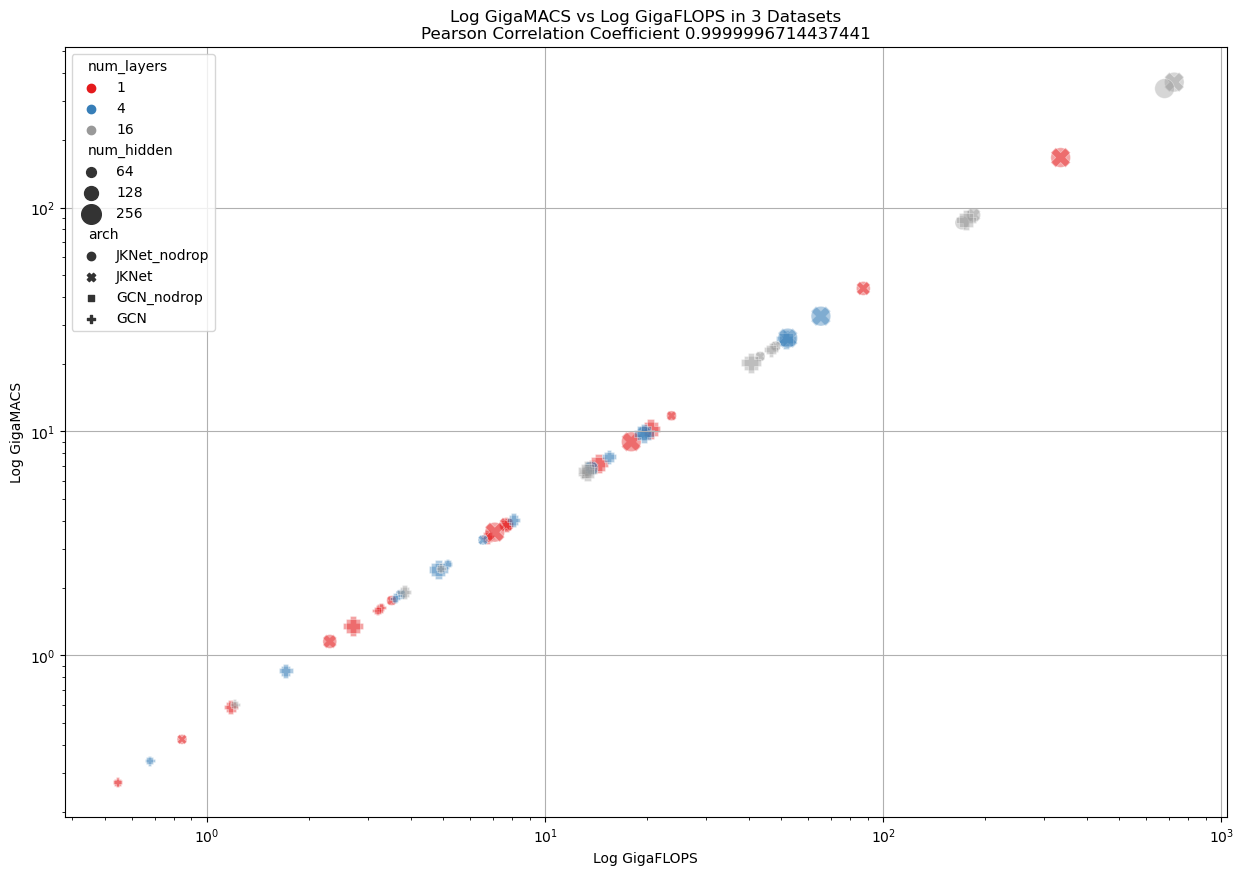

In [166]:
plt.figure(figsize=(15,10))
sns.scatterplot(df, x='gflops', y='gmacs',hue='num_layers',style='arch',size='num_hidden', sizes={64:50,128:100,256:200,},palette=palette,alpha=0.4)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title(f'Log GigaMACS vs Log GigaFLOPS in 3 Datasets\nPearson Correlation Coefficient {df[['gmacs','gflops']].corr()['gmacs']['gflops']}')
plt.ylabel('Log GigaMACS')
plt.xlabel('Log GigaFLOPS')
plt.savefig('peason.png')
plt.show()

In [67]:
df.to_csv('flops_macs.csv')

In [161]:
df_sorted = df.sort_values(['dataset','num_layers','num_hidden','arch'])

In [163]:
df_sorted['acc_test_diff'] = df_sorted.groupby(['num_layers', 'num_hidden'])['acc_test'].diff()

In [164]:
df_sorted

,arch,dataset,num_layers,num_hidden,acc_test,gflops,gmacs,acc_test_diff
59,GCN,citeseer,1,64,64.2,3.269336,1.634009,NaN
22,GCN_nodrop,citeseer,1,64,75.4,3.269336,1.634009,11.2
9,JKNet,citeseer,1,64,77.8,3.516719,1.758359,2.4
32,JKNet_nodrop,citeseer,1,64,76.4,3.516719,1.758359,-1.4
0,GCN,citeseer,1,128,76.6,6.756671,3.377038,NaN
...,...,...,...,...,...,...,...,...
18,GCN_nodrop,pubmed,16,64,81.7,12.959708,6.438153,30.5
25,GCN,pubmed,16,128,72.3,46.594071,23.213692,-12.9
56,GCN_nodrop,pubmed,16,128,18.0,46.594071,23.213692,-54.3
66,GCN,pubmed,16,256,49.9,175.887115,87.776929,-35.0
